In [31]:
import sys
import os
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

sys.path.append(os.path.abspath(".."))
from src.preprocessing import encode_categories
from src.inference import hierarchical_predict

In [8]:
df= pd.read_csv("../data/iot23_clean.csv")

In [10]:
#transformer en catégorie
df = encode_categories(df)

## 1. Modélisation

### 1.1 Baseline

In [46]:
df_model = df.sample(n=5146622, random_state=42).copy()


X = df_model.drop('label', axis=1)
y = df_model['label'].copy()
    
# Encoder la cible
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)


# Encoder les catégorielles
for col in ['proto', 'service', 'conn_state']:
    X[col] = X[col].cat.codes


# TRAIN/TEST
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42,
    stratify=y_encoded
)

# ENTRAÎNEMENT
rf_model = RandomForestClassifier(
    n_estimators=200,           
    max_depth=25,               
    min_samples_split=50,
    min_samples_leaf=20,
    max_features='sqrt',        
    random_state=42,
    n_jobs=-1,
    class_weight='balanced_subsample',
    bootstrap=True
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced_subsample', max_depth=25,
                       min_samples_leaf=20, min_samples_split=50,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [47]:
# PRÉDICTIONS
y_pred = rf_model.predict(X_test)

# 8. ÉVALUATION
print("\n" + "=" * 80)
print("RÉSULTATS")
print("=" * 80)

accuracy = accuracy_score(y_test, y_pred)
print(f"\n🎯 Accuracy globale : {accuracy:.2%}")

print(classification_report(
    y_test, y_pred, 
    target_names=le_target.classes_,
    digits=3
))


RÉSULTATS

🎯 Accuracy globale : 61.65%
               precision    recall  f1-score   support

       Benign      0.981     0.379     0.547    117267
          C&C      0.044     0.722     0.083      2822
         DDoS      0.999     0.805     0.892    108754
Malware_Okiru      0.397     0.904     0.552    223512
  Scan_Attack      0.875     0.517     0.650    576970

     accuracy                          0.617   1029325
    macro avg      0.659     0.666     0.545   1029325
 weighted avg      0.794     0.617     0.641   1029325



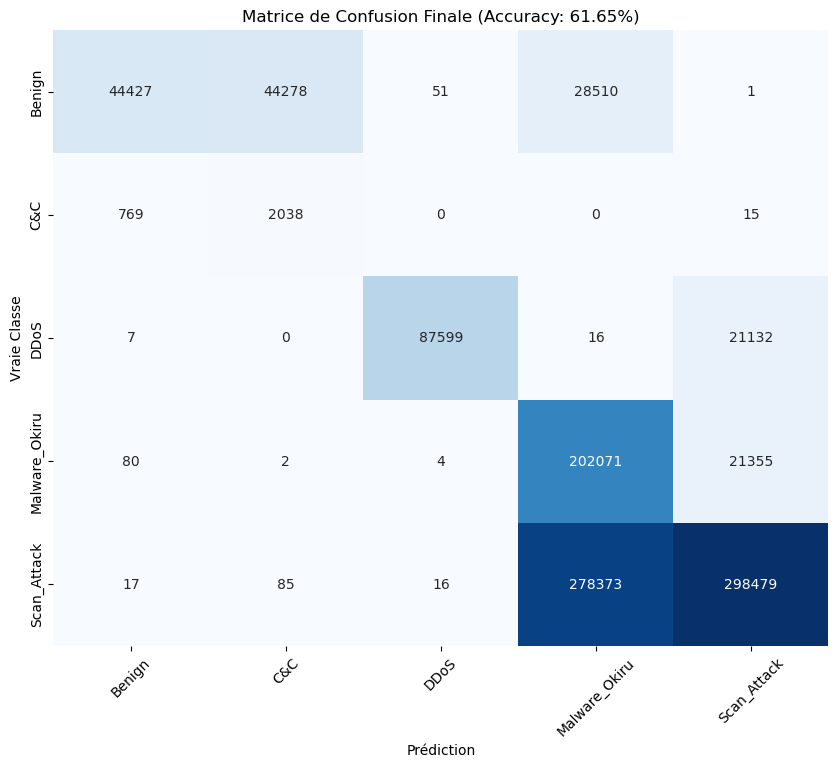

In [49]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, 
                     index=le_target.classes_, 
                     columns=le_target.classes_)

# --- 1. VISUALISATION DE LA MATRICE DE CONFUSION ---
plt.figure(figsize=(10, 8))
# On reprend ton cm_df calculé juste avant
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Matrice de Confusion Finale (Accuracy: {accuracy:.2%})')
plt.ylabel('Vraie Classe')
plt.xlabel('Prédiction')
plt.xticks(rotation=45)
plt.show()

### 1.2 Improved model

In [50]:
# Échantillonnage
df_model = df.sample(n=5046622, random_state=42).copy()

X = df_model.drop('label', axis=1).copy()

# Encoder les catégorielles
for col in ['proto', 'service', 'conn_state']:
    X[col] = X[col].cat.codes


# ============================================
# ÉTAPE 1 : DÉTECTION D'ATTAQUE
# ============================================

# Créer la cible binaire
y_binary = (df_model['label'] != 'Benign').astype(int)
y_binary_labels = y_binary.map({0: 'Benign', 1: 'Attaque'})

print(f"\nDistribution :")
print(y_binary_labels.value_counts())

# Split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

# Modèle 1 : Détection d'attaque
model_1 = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
model_1.fit(X_train_1, y_train_1)

# Prédictions
y_pred_1 = model_1.predict(X_test_1)

# Évaluation
print("\n📊 RÉSULTATS MODÈLE 1 :")
print(f"Accuracy : {accuracy_score(y_test_1, y_pred_1):.2%}\n")
print(classification_report(
    y_test_1, y_pred_1,
    target_names=['Benign', 'Attaque'],
    digits=3
))

# Matrice de confusion
cm_1 = confusion_matrix(y_test_1, y_pred_1)
cm_1_df = pd.DataFrame(cm_1, 
                       index=['Benign (vrai)', 'Attaque (vrai)'],
                       columns=['Benign (prédit)', 'Attaque (prédit)'])
print("Matrice de confusion :")
print(cm_1_df)



Distribution :
label
Attaque    4471654
Benign      574968
Name: count, dtype: int64

📊 RÉSULTATS MODÈLE 1 :
Accuracy : 96.97%

              precision    recall  f1-score   support

      Benign      0.972     0.756     0.851    114994
     Attaque      0.970     0.997     0.983    894331

    accuracy                          0.970   1009325
   macro avg      0.971     0.877     0.917   1009325
weighted avg      0.970     0.970     0.968   1009325

Matrice de confusion :
                Benign (prédit)  Attaque (prédit)
Benign (vrai)             86978             28016
Attaque (vrai)             2548            891783


In [54]:

# ============================================
# ÉTAPE 2 : CLASSIFICATION DES ATTAQUES
# ============================================

# Filtrer uniquement les attaques
df_attacks = df_model[df_model['label'] != 'Benign'].copy()
X_attacks = X.loc[df_attacks.index]
y_attacks = df_attacks['label']

print(f"\nNombre d'attaques : {len(df_attacks):,}")
print(f"\nDistribution des types d'attaques :")
print(y_attacks.value_counts())

# Encoder les labels d'attaques
le_attacks = LabelEncoder()
y_attacks_encoded = le_attacks.fit_transform(y_attacks)

# Split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_attacks, y_attacks_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_attacks_encoded
)

# Modèle 2 : Classification des attaques
model_2 = RandomForestClassifier(
    n_estimators=200,           
    max_depth=25,               
    min_samples_split=50,
    min_samples_leaf=20,
    max_features='sqrt',        
    random_state=42,
    n_jobs=-1,
    class_weight='balanced_subsample',
    bootstrap=True
)
model_2.fit(X_train_2, y_train_2)

# Prédictions
y_pred_2 = model_2.predict(X_test_2)

# Évaluation
print(f"Accuracy : {accuracy_score(y_test_2, y_pred_2):.2%}\n")
print(classification_report(
    y_test_2, y_pred_2,
    target_names=le_attacks.classes_,
    digits=3
))

# Matrice de confusion
cm_2 = confusion_matrix(y_test_2, y_pred_2)
cm_2_df = pd.DataFrame(cm_2, 
                       index=le_attacks.classes_,
                       columns=le_attacks.classes_)
print("Matrice de confusion :")
print(cm_2_df)


Nombre d'attaques : 4,471,654

Distribution des types d'attaques :
label
Scan_Attack      2828775
Malware_Okiru    1096027
DDoS              533034
C&C                13818
Name: count, dtype: int64
Accuracy : 64.60%

               precision    recall  f1-score   support

          C&C      0.956     0.993     0.974      2764
         DDoS      1.000     0.803     0.891    106607
Malware_Okiru      0.419     0.904     0.573    219205
  Scan_Attack      0.874     0.515     0.648    565755

     accuracy                          0.646    894331
    macro avg      0.812     0.804     0.772    894331
 weighted avg      0.778     0.646     0.660    894331

Matrice de confusion :
                C&C   DDoS  Malware_Okiru  Scan_Attack
C&C            2746      0              0           18
DDoS             10  85624             21        20952
Malware_Okiru     6      1         198081        21117
Scan_Attack     110     13         274310       291322


In [56]:
# ==========================
# ÉVALUATION HIÉRARCHIQUE
# ==========================

# Étape 1 : prédiction binaire
y_pred_stage1 = model_1.predict(X_test_1)

# Indices prédits comme attaques
attack_idx = X_test_1.index[y_pred_stage1 == 1]

print(f"🔍 Flux envoyés au modèle 2 : {len(attack_idx):,}")

# Étape 2 : récupération des vraies classes
X_stage2_real = X.loc[attack_idx]
y_stage2_real = df.loc[attack_idx, 'label']

mask_attack = y_stage2_real != 'Benign'
X_stage2_real = X_stage2_real.loc[mask_attack]
y_stage2_real = y_stage2_real[mask_attack]

print(f"🎯 Vraies attaques classifiées : {len(y_stage2_real):,}")

# Encodage (maintenant sûr)
y_stage2_real_enc = le_attacks.transform(y_stage2_real)

# Prédiction stage 2
y_pred_stage2 = model_2.predict(X_stage2_real)

# Résultats
print("\n📊 RÉSULTATS HIÉRARCHIQUES FINAUX :")
print(classification_report(
    y_stage2_real_enc,
    y_pred_stage2,
    target_names=le_attacks.classes_,
    digits=3
))


🔍 Flux envoyés au modèle 2 : 919,799
🎯 Vraies attaques classifiées : 891,783

📊 RÉSULTATS HIÉRARCHIQUES FINAUX :
               precision    recall  f1-score   support

          C&C      0.771     0.975     0.861       401
         DDoS      1.000     0.803     0.891    105915
Malware_Okiru      0.419     0.905     0.573    219373
  Scan_Attack      0.875     0.515     0.648    566094

     accuracy                          0.645    891783
    macro avg      0.766     0.799     0.743    891783
 weighted avg      0.778     0.645     0.659    891783



In [57]:
# Modèles
joblib.dump(model_1, "../models/attack_detector.joblib")
joblib.dump(model_2, "../models/attack_classifier.joblib")

# Encoder des attaques
joblib.dump(le_attacks, "../models/label_encoder_attack.joblib")

print("✅ Modèles sauvegardés")

✅ Modèles sauvegardés
